# Importing libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from dataclasses import dataclass, field

import warnings
warnings.filterwarnings('ignore')

from sklearn.base import BaseEstimator, TransformerMixin

# Data imputation
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer, PolynomialFeatures

# Feature Selection
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression, SelectKBest

# Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor

# Performance metrics 
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score



from sklearn.pipeline import Pipeline





In [2]:
# Change some pandas display options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option("precision", 10)

# Data acquisition

In [3]:
# Read data
df_house = pd.read_csv("kc_house_data.csv")
df_house_full = df_house.copy()
df_house = df_house.drop(columns=['id','zipcode','date'])

# Splite data to train and test df
df_train, df_test = train_test_split(df_house, test_size=0.3, random_state=33)

# Reset index for each df for later modification
# df_train.reset_index(drop=True, inplace=True)
# df_test.reset_index(drop=True, inplace=True)


# Edit date feature
# df_house['date'] = df_house['date'].apply(lambda item: item[:8])
# df_house['date'] = pd.to_datetime(df_house['date'], format='%Y%m%d', errors='ignore').astype('object')

In [4]:
df_train.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
7543,625000.0,2,1.00,1100,4160,1.0,0,0,3,7,1100,0,1919,0,47.6352,-122.352,1900,4000
6160,216600.0,3,1.75,2200,7700,1.0,0,0,3,7,1240,960,1975,0,47.4119,-122.181,1770,7360
6610,472500.0,3,2.50,1650,3711,2.0,0,0,3,8,1650,0,1996,0,47.6863,-122.093,1760,3762
17037,269950.0,3,2.50,1480,9743,2.0,0,0,4,7,1480,0,1996,0,47.3293,-122.001,1810,9601
18766,443000.0,3,1.75,1810,7950,1.0,0,0,4,7,1810,0,1968,0,47.6236,-122.117,1680,7725


# Train/Test split

In [7]:
X_train, y_train = df_train.drop(columns=['price']), df_train['price']
X_test, y_test = df_test.drop(columns=['price']), df_test['price']

# Data modeling

In [8]:
class OutliersRemover(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
        
    def fit(self, X:pd.DataFrame, y:pd.DataFrame=None):
        X_copy = X.copy()
 
        # index_condition = X_copy[
        #     (y_copy['price']>7_000_000) | (X_copy['sqft_living']>13_000) | (X_copy['sqft_lot']>1.5e6) | (X_copy['sqft_basement']>4_000) | (X_copy['sqft_lot15']>8_00_000)
        # ].index
        index_condition = X_copy[
            (X_copy['sqft_living']>13_000) | (X_copy['sqft_lot']>1.5e6) | (X_copy['sqft_basement']>4_000) | (X_copy['sqft_lot15']>8_00_000)
        ].index

        X_copy = X_copy.drop(index= index_condition)

        return X_copy
    
    def transform(self, X):
        # When doing prediction should return X and doesn't apply transformer on it
        return X
    
    def fit_transform(self, X, y=None):
        return self.transform(X)
        

class FeaturesRemover(BaseEstimator, TransformerMixin):
    def __init__(self, removed_features:list[str]):
        self.removed_features = removed_features
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        output:pd.DataFrame = X.copy()
 
        output = output.drop(columns=self.removed_features)

        return output
    
    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)


    

# Modeling

## Linear Regression

In [9]:
num_of_selected_feats = 9

lr_model = Pipeline(steps=[
    ('Remove Outliers', OutliersRemover()),
    ('Remove features', FeaturesRemover(removed_features=['sqft_living15', 'sqft_above', 'sqft_lot15'])),
    ("selection", SelectKBest(mutual_info_regression, k=num_of_selected_feats)),
    ("Normalization", MinMaxScaler()),
    ("Linear Regression", LinearRegression())
])
lr_model.fit(X_train, y_train)


Pipeline(steps=[('Remove Outliers', OutliersRemover()),
                ('Remove features',
                 FeaturesRemover(removed_features=['sqft_living15',
                                                   'sqft_above',
                                                   'sqft_lot15'])),
                ('selection',
                 SelectKBest(k=9,
                             score_func=<function mutual_info_regression at 0x000001F12919A040>)),
                ('Normalization', MinMaxScaler()),
                ('Linear Regression', LinearRegression())])

## Polynomial Regression
*Observation*:
- We make some accuracy improvements in prediction the price

In [10]:
poly_model = Pipeline(steps=[
    ('Remove Outliers', OutliersRemover()),
    ('Remove features', FeaturesRemover(['sqft_living15', 'sqft_above', 'sqft_lot15'] )),
    ("selection", SelectKBest(mutual_info_regression, k=num_of_selected_feats)),
    ("Normalization", MinMaxScaler()),
    ("Polynomial Features", PolynomialFeatures(degree=2)),
    ("Linear Regression", LinearRegression())
                        ])
poly_model.fit(X_train, y_train)



Pipeline(steps=[('Remove Outliers', OutliersRemover()),
                ('Remove features',
                 FeaturesRemover(removed_features=['sqft_living15',
                                                   'sqft_above',
                                                   'sqft_lot15'])),
                ('selection',
                 SelectKBest(k=9,
                             score_func=<function mutual_info_regression at 0x000001F12919A040>)),
                ('Normalization', MinMaxScaler()),
                ('Polynomial Features', PolynomialFeatures()),
                ('Linear Regression', LinearRegression())])

In [11]:
ploy_no_prep_model = Pipeline(steps=[
                            ("Polynomial Features", PolynomialFeatures(degree=2)),
                            ("Linear Regression", LinearRegression())
                        ])
ploy_no_prep_model.fit(X_train, y_train)



Pipeline(steps=[('Polynomial Features', PolynomialFeatures()),
                ('Linear Regression', LinearRegression())])

## Ridge Regression
- We notice adding regularization parameter doesn't make any improvement in accuracy

In [12]:

ridge_model = Pipeline(steps=[
    ('Remove Outliers', OutliersRemover()),
    ('Remove features', FeaturesRemover(removed_features=['sqft_living15', 'sqft_above', 'sqft_lot15'])),
    ("selection", SelectKBest(mutual_info_regression, k=num_of_selected_feats)),
    ("Normalization", MinMaxScaler()),
    ("Polynomial Features", PolynomialFeatures(degree=2)),
    ("Ridge Regression", Ridge(alpha=0.1, random_state=0))
    ])
                        
ridge_model.fit(X_train, y_train)


Pipeline(steps=[('Remove Outliers', OutliersRemover()),
                ('Remove features',
                 FeaturesRemover(removed_features=['sqft_living15',
                                                   'sqft_above',
                                                   'sqft_lot15'])),
                ('selection',
                 SelectKBest(k=9,
                             score_func=<function mutual_info_regression at 0x000001F12919A040>)),
                ('Normalization', MinMaxScaler()),
                ('Polynomial Features', PolynomialFeatures()),
                ('Ridge Regression', Ridge(alpha=0.1, random_state=0))])

## Lasso Regression

In [13]:
lasso_model = Pipeline(steps=[
    ('Remove Outliers', OutliersRemover()),
    ('Remove features', FeaturesRemover(removed_features=['sqft_living15', 'sqft_above', 'sqft_lot15'])),
    ("selection", SelectKBest(mutual_info_regression, k=num_of_selected_feats)),
    ("Normalization", MinMaxScaler()),
    ("Polynomial Features", PolynomialFeatures(degree=2)),
    ("lasso Regression", Lasso(alpha=0.1, random_state=0))
    ])
                        
lasso_model.fit(X_train, y_train)


Pipeline(steps=[('Remove Outliers', OutliersRemover()),
                ('Remove features',
                 FeaturesRemover(removed_features=['sqft_living15',
                                                   'sqft_above',
                                                   'sqft_lot15'])),
                ('selection',
                 SelectKBest(k=9,
                             score_func=<function mutual_info_regression at 0x000001F12919A040>)),
                ('Normalization', MinMaxScaler()),
                ('Polynomial Features', PolynomialFeatures()),
                ('lasso Regression', Lasso(alpha=0.1, random_state=0))])

# Reporting
**Summary**:
- **Linear Regression** yields lower accuracy comparing to other models.
- Looking at scattered data, then adopt polynomial methodology will give better performance since most relationships are non-linear.
- **Ridge** & **Lasso** & **Polynomial Regression** give close accuracy to each other.



In [14]:
@dataclass
class FittedEstimator:
    """
    Class to store fitted estimator and its name
    """
    name: str
    details: str 
    fitted_model: object
    n_fitted_features: int
    X_train: pd.DataFrame
    y_train: pd.Series
    X_test: pd.DataFrame
    y_test: pd.Series

    rmse: float = field(init=False)
    r2_train: float = field(init=False)
    r2_test: float = field(init=False)
    r2_adj_train: float = field(init=False)
    r2_adj_test: float = field(init=False)
    cv_score: float = field(init=False)

    def __post_init__(self):
        self.rmse = float(f"{np.sqrt(mean_squared_error(self.y_test, self.fitted_model.predict(self.X_test))):.3f}")
        
        self.r2_train = float(f"{self.fitted_model.score(self.X_train, self.y_train):.3f}")
        self.r2_adj_train = float(f"{self.adjusted_r2(self.X_train.shape[0], self.n_fitted_features, self.r2_train):.3f}")
        
        self.r2_test = float(f"{self.fitted_model.score(self.X_test, self.y_test):.3f}")
        self.r2_adj_test = float(f"{self.adjusted_r2(self.X_test.shape[0], self.n_fitted_features, self.r2_test):.3f}")
        
        self.cv_score = float(f"{cross_val_score(self.fitted_model, self.X_train, self.y_train, cv=10).mean():.3f}")
    

    def adjusted_r2(self, n:int, k:int, r2:float):
        """
        Calculate the adjusted r2

        Parameters:
        -----------
        n: number of samples
        k: number of features
        r2: r2 score
        """

        return (1- (1-r2) * (n-1)/(n-k-1))

class Evaluation:
    def __init__(self, estimators: list[(str, FittedEstimator)]):
        self.estimators = estimators
        
    @property
    def eval(self):
        """Evaluate each estimator and add to evaluation DataFrame"""

        values:pd.DataFrame = pd.DataFrame({'Model': [],
                            'Details':[],
                            'Root Mean Squared Error (RMSE)':[],
                            'R-squared (training)':[],
                            'Adjusted R-squared (training)':[],
                            'R-squared (test)':[],
                            'Adjusted R-squared (test)':[],
                            '10-Fold Cross Validation':[]})


        for estimator in self.estimators:
         
            values.loc[len(values)] = [estimator.name, estimator.details, estimator.rmse, estimator.r2_train, estimator.r2_adj_train, estimator.r2_test, estimator.r2_adj_test, estimator.cv_score]
        
        return values

    def plot_cv_scores(self):
        """Plot bar for cross validation scores"""
        figure = plt.figure(figsize=(10,5))
        ax = figure.add_subplot(111)
        sns.barplot(x='Model', y='10-Fold Cross Validation', data=self.eval)
        
        ax.bar_label(ax.containers[-1], fmt='CV:\n%.2f', label_type='center')


        ax.set_title('10-Fold Cross Validation Scores')
        ax.set_xlabel('Model')
        ax.set_ylabel('Score')
    
    def plot_r2_scores(self):
        """Plot bar for cross validation scores"""
        figure = plt.figure(figsize=(10,5))
        ax = figure.add_subplot(111)
        sns.barplot(x='Model', y='R-squared (test)', data=self.eval)

        ax.bar_label(ax.containers[-1], fmt='R-squared:\n%.2f', label_type='center')
    
        ax.set_title('R-squared (test) Scores')
        ax.set_xlabel('Model')
        ax.set_ylabel('Score')


    
    

In [15]:
lr_f_estimator = FittedEstimator('LR', '9 best features', lr_model, num_of_selected_feats, X_train, y_train, X_test, y_test)
poly_f_estimator = FittedEstimator('Polynomial', '9 best features', poly_model, poly_model.get_params()['Polynomial Features'].n_output_features_, X_train, y_train, X_test, y_test)
poly_no_pre_f_estimator = FittedEstimator('Polynomial no preprocess', 'all features', ploy_no_prep_model, ploy_no_prep_model.get_params()['Polynomial Features'].n_output_features_, X_train, y_train, X_test, y_test)
ridge_f_estimator = FittedEstimator('Ridge', '9 best features', ridge_model, ridge_model.get_params()['Polynomial Features'].n_output_features_, X_train, y_train, X_test, y_test)
lasso_f_estimator = FittedEstimator('Lasso', '9 best features', lasso_model, lasso_model.get_params()['Polynomial Features'].n_output_features_, X_train, y_train, X_test, y_test)



In [16]:
report = Evaluation([
    lr_f_estimator,
    poly_f_estimator,
    poly_no_pre_f_estimator,
    ridge_f_estimator,
    lasso_f_estimator
])

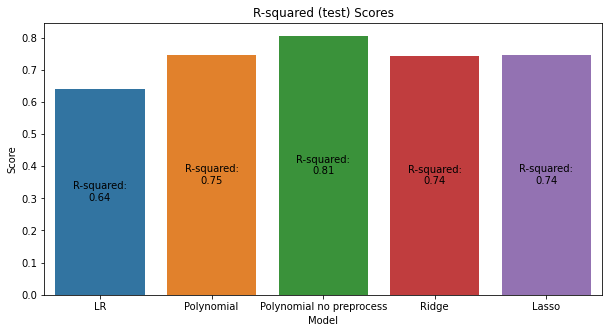

In [17]:
report.plot_r2_scores()